In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# EDA 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from scipy.stats import skew
from scipy.stats import spearmanr

# Learning algorithms
import sklearn
from sklearn.linear_model import *
from sklearn.svm import SVR
from sklearn.cluster import KMeans


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
ss = pd.read_csv('data/sample_submission.csv')

In [3]:
# 컬럼명 영문으로 변경하기
train_df.columns = ['num','datetime','target','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']
test_df.columns = ['num','datetime','temperature','windspeed','humidity','precipitation','insolation','nelec_cool_flag','solar_flag']

In [4]:
train_df.shape

(122400, 10)

In [5]:
train_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


비가 오는 날과 맑은 날의 전력 사용량에 차이가 날 것 이라 생각이 들었고, 날씨와 전력 사용량의 상관 관계를 알아보면 좋겠다는 생각이 들었습니다.

그래서 weather이라는 컬럼을 새로 만들고, 비오는 날을 0, 흐린 날을 0.5, 맑은 날을 1로 값을 주었습니다.

- 비오는날
    - 강수량 > 0
- 흐린 날
    - 강수량 = 0, 일조량
- 맑은 날
    - 강수량 = 0, 일조량 = 1
    - 강수량 = 0, 일조량 = 0 , 습도 
    
흐린 날과, 맑은 날의 데이터를 뽑기 위해 일조량과 습도를 알아내고 싶었습니다.

그래서 비오는 날의 dataframe과 비가 오지 않는 날의 dataframe을 뽑아내고, 습도, 강수량, 일조에 대한 데이터를 뽑아 보았습니다.

In [6]:
rainy_df = train_df[train_df['precipitation']>0]

print(rainy_df.shape)

(18927, 10)


In [7]:
not_rainy_df = train_df[train_df['precipitation']==0]

print(not_rainy_df.shape)

(103473, 10)


122400개의 데이터 중, 비가 오는 data는 18927개, 비가 오지 않는 data는 103473개가 있습니다.

비오는날의 일조량, 습도를 뽑아 보는데, 해가 뜬 시간과 해가 저문 시간에 따라 일조량과 습도가 다를 것 같아, 06\~18시 까지는 day time, 00\~06, 18\~23는 night time으로 나누어 일조량과 습도를 뽑아보았습니다.

시간으로 나누어 주기 위해, rainy dataframe과 not rainy dataframe에 hour column을 추가해주었습니다.

In [8]:
rainy_df['datetime'] = pd.to_datetime(rainy_df['datetime'])
rainy_df['hour'] = rainy_df['datetime'].dt.hour

rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6
36,1,2020-06-02 12:00:00,7935.408,16.3,2.9,80.0,1.9,0.0,0.0,0.0,12
48,1,2020-06-03 00:00:00,8114.904,18.4,1.7,84.0,0.1,0.0,0.0,0.0,0


In [9]:
not_rainy_df['datetime'] = pd.to_datetime(not_rainy_df['datetime'])
not_rainy_df['hour'] = not_rainy_df['datetime'].dt.hour

not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7


# rainy_df 에 'weather'컬럼을 추가해서 'rainy'값으로 초기화 해주었습니다.

In [10]:
rainy_df['weather'] = 'rainy'

In [11]:
rainy_df.head(100)

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,0,rainy
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,1,rainy
6,1,2020-06-01 06:00:00,7978.176,16.7,3.4,90.0,0.1,0.0,0.0,0.0,6,rainy
36,1,2020-06-02 12:00:00,7935.408,16.3,2.9,80.0,1.9,0.0,0.0,0.0,12,rainy
48,1,2020-06-03 00:00:00,8114.904,18.4,1.7,84.0,0.1,0.0,0.0,0.0,0,rainy
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,1,2020-07-13 19:00:00,8473.896,18.6,4.7,95.0,0.7,0.0,0.0,0.0,19,rainy
1028,1,2020-07-13 20:00:00,8468.712,18.2,4.2,96.0,1.5,0.0,0.0,0.0,20,rainy
1029,1,2020-07-13 21:00:00,8481.024,18.1,4.9,96.0,1.0,0.0,0.0,0.0,21,rainy
1030,1,2020-07-13 22:00:00,8468.712,18.1,4.3,96.0,1.4,0.0,0.0,0.0,22,rainy


# 비가 오지 않는 날에서 맑음과 흐림을 구별하기 위해서는, daytime과 night time을 구별해주어야 함.(일조량을 사용하여 판별할것이기 때문.)

In [12]:
# daytime_rainy_df = rainy_df[rainy_df['precipitation']==0]
# daytime_rainy_df = rainy_df[(rainy_df['hour']>6) & (rainy_df['hour']<18)]
# """he truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all()."""
# daytime_rainy_df=pd.DataFrame()
# daytime_rainy_df = rainy_df[rainy_df['hour']>6 and rainy_df['hour']<18]


condition = (not_rainy_df.hour >5)& (not_rainy_df.hour<21)
daytime_not_rainy_df = not_rainy_df[condition]

In [13]:
print(daytime_not_rainy_df['hour'].min(),daytime_not_rainy_df['hour'].max())
print(daytime_not_rainy_df['hour'].min(),
      daytime_not_rainy_df[daytime_not_rainy_df['hour']<8]['hour'].max(),
      daytime_not_rainy_df[daytime_not_rainy_df['hour']>15]['hour'].min(),
      daytime_not_rainy_df['hour'].max())

6 20
6 7 16 20


In [14]:
daytime_not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,8
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,9
10,1,2020-06-01 10:00:00,8116.200,20.5,3.4,62.0,0.0,1.0,0.0,0.0,10
11,1,2020-06-01 11:00:00,8104.536,22.1,3.6,52.0,0.0,1.0,0.0,0.0,11


In [15]:
condition = (not_rainy_df.hour <=5) | (not_rainy_df.hour>=21)
nightTime_not_rainy_df = not_rainy_df[condition]

In [16]:
print(nightTime_not_rainy_df['hour'].min(),
      nightTime_not_rainy_df[nightTime_not_rainy_df['hour']<8]['hour'].max(),
      nightTime_not_rainy_df[nightTime_not_rainy_df['hour']>15]['hour'].min(),
      nightTime_not_rainy_df['hour'].max())

0 5 21 23


# nightTime_not_rainy_df가 0\~6시, 8\~23시 시간을 포함하도록 잘 나뉜것을 확인하였습니다.

In [17]:
nightTime_not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5
21,1,2020-06-01 21:00:00,7974.936,18.6,2.5,55.0,0.0,0.0,0.0,0.0,21


# 비오는날의 Daytime과 Night Time의 컬럼 Split 끝남!

이제 날씨 컬럼을 추가해주어야 하는데, 일과시간에 일조량을 살펴보기 위하여 precipitation 컬럼의 min / max / median / mean값을 출력해보았습니다.

6-8월 날씨는 대체로 무더우니, 대체로 맑은날씨로 할 예정입니다.??????????

In [18]:
print(daytime_not_rainy_df['insolation'].min())
print(daytime_not_rainy_df['insolation'].max())
print(daytime_not_rainy_df['insolation'].median())
print(daytime_not_rainy_df['insolation'].mean())


0.0
1.0
0.2
0.4028427603032649


<AxesSubplot:xlabel='insolation', ylabel='datetime'>

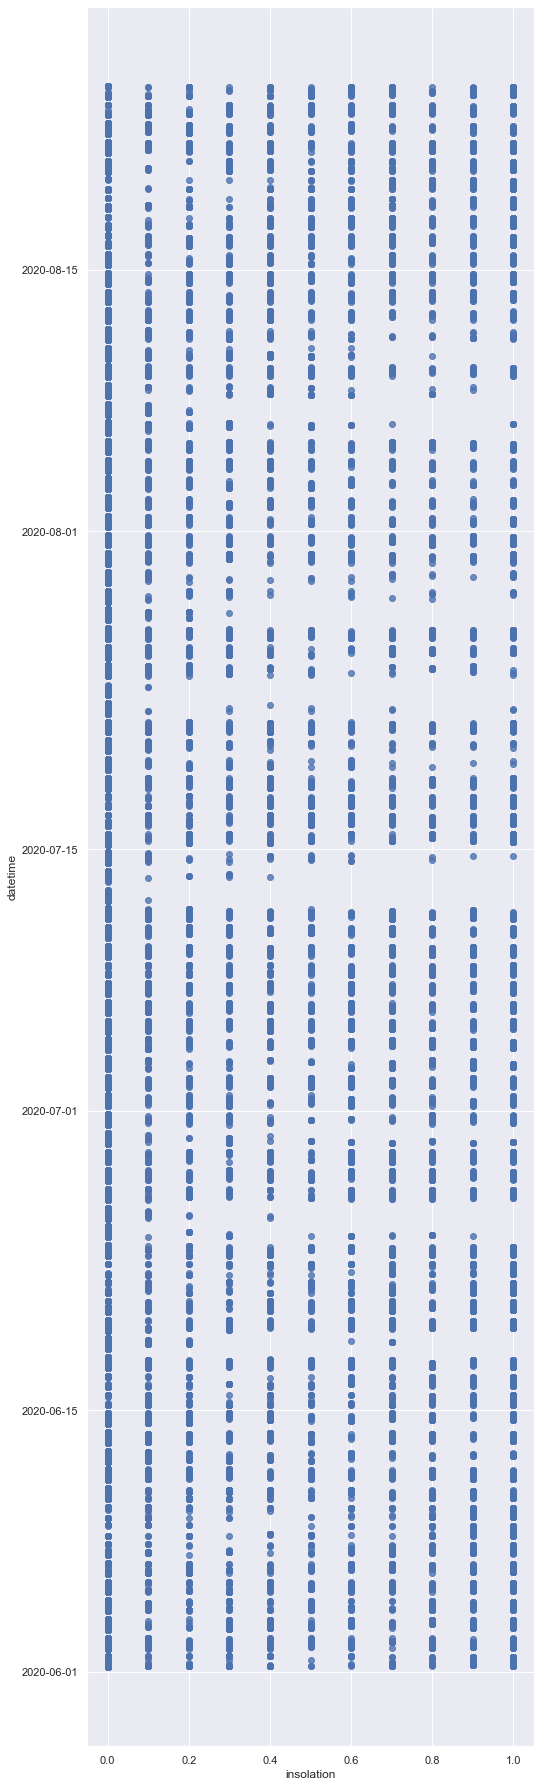

In [19]:
sns.set(rc = {'figure.figsize':(8,32)})

sns.regplot(x=daytime_not_rainy_df['insolation'], y=daytime_not_rainy_df['datetime'], 
           fit_reg=False)

datetime이 시간대별로 되어 있어서, 데이터의 분포를 전체적으로 알아보기가 힘들었습니다. 일자별로 일조량의 평균을 구한 다음, 그걸 scatter 그래프로 그려보았습니다.

In [20]:
perDay_insolation = pd.DataFrame()
perDay_insolation['datetime'] = daytime_not_rainy_df['datetime']
perDay_insolation['insolation'] = daytime_not_rainy_df['insolation']


In [21]:
perDay_insolation.head()

,datetime,insolation
7,2020-06-01 07:00:00,0.1
8,2020-06-01 08:00:00,0.3
9,2020-06-01 09:00:00,0.7
10,2020-06-01 10:00:00,1.0
11,2020-06-01 11:00:00,1.0


In [22]:
# perDay_insolation['datetime']=perDay_insolation['datetime'].astype(str)+'-'
perDay_insolation['mm-dd']=perDay_insolation['datetime'].dt.month
perDay_insolation.head()

,datetime,insolation,mm-dd
7,2020-06-01 07:00:00,0.1,6
8,2020-06-01 08:00:00,0.3,6
9,2020-06-01 09:00:00,0.7,6
10,2020-06-01 10:00:00,1.0,6
11,2020-06-01 11:00:00,1.0,6


In [23]:
perDay_insolation['mm-dd']=perDay_insolation['mm-dd'].astype(str)+'/'
perDay_insolation.head()

,datetime,insolation,mm-dd
7,2020-06-01 07:00:00,0.1,6/
8,2020-06-01 08:00:00,0.3,6/
9,2020-06-01 09:00:00,0.7,6/
10,2020-06-01 10:00:00,1.0,6/
11,2020-06-01 11:00:00,1.0,6/


In [24]:
perDay_insolation['mm-dd']=perDay_insolation['mm-dd'].astype(str) + perDay_insolation['datetime'].dt.day.astype(str)

In [25]:
perDay_insolation.head()

,datetime,insolation,mm-dd
7,2020-06-01 07:00:00,0.1,6/1
8,2020-06-01 08:00:00,0.3,6/1
9,2020-06-01 09:00:00,0.7,6/1
10,2020-06-01 10:00:00,1.0,6/1
11,2020-06-01 11:00:00,1.0,6/1


In [26]:
perDay_insolation.groupby('mm-dd')['insolation'].mean().round(3)

mm-dd
6/1     0.766
6/10    0.569
6/11    0.504
6/12    0.109
6/13    0.505
        ...  
8/5     0.161
8/6     0.063
8/7     0.008
8/8     0.098
8/9     0.316
Name: insolation, Length: 85, dtype: float64

In [27]:
groupby = perDay_insolation['mm-dd'].
groupby.head()

SyntaxError: invalid syntax (Temp/ipykernel_17232/2020468041.py, line 1)

<AxesSubplot:xlabel='insolation'>

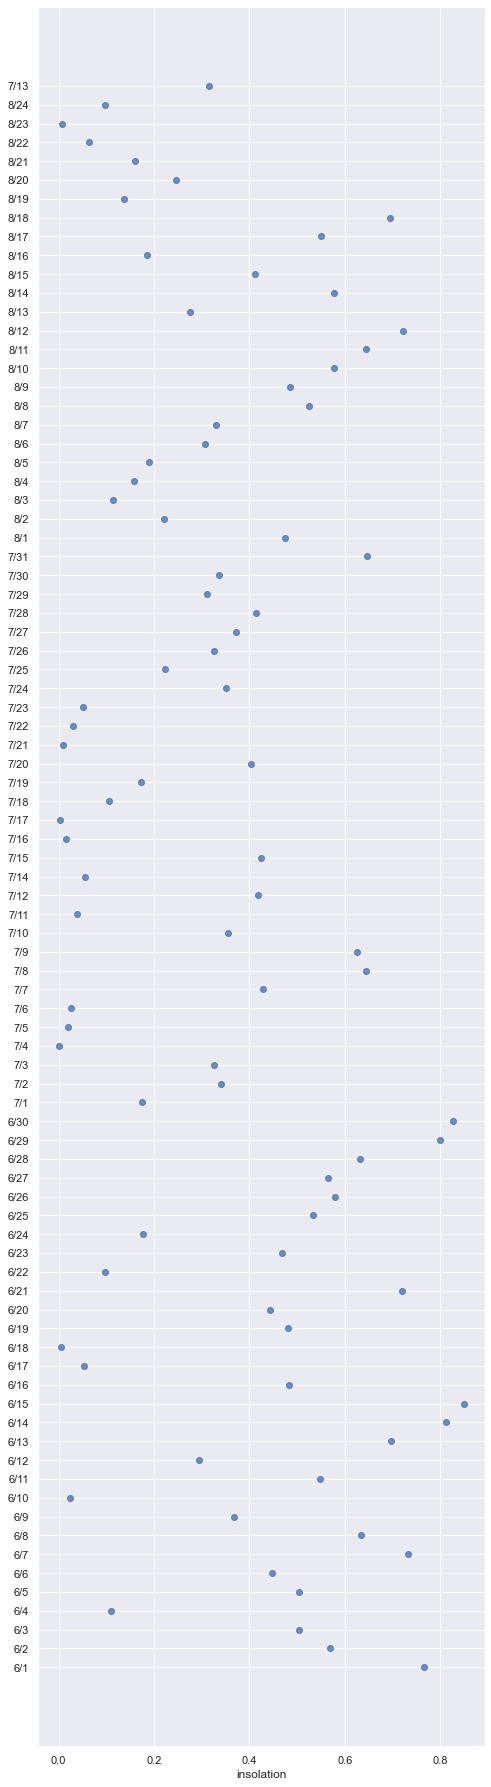

In [28]:
sns.set(rc = {'figure.figsize':(8,32)})

sns.regplot(y=perDay_insolation['mm-dd'].unique(), x = perDay_insolation.groupby('mm-dd')['insolation'].mean().round(3),
           fit_reg=False)

맑은날과 흐린날을 구별할 기준을 정하기 위해 위와 같은 그래프를 그려보았습니다.
강수량이 0인날에, 일별로 모든 건물들의 일조량의 평균을 구한 것입니다.

흐린날과 맑은날을 어떻게 나눌지에 대해 저희 조에서 의견을 나눈 결과 일조량의 평균이 0.2이하면 흐린날, 나머지는 맑은 날로 결정하였습니다.

그래프를 보고 임의로 기준을 나눈 것인데, 정확한 기준점을 찾아보려 했으나 회의결과 임의로 나누는 것이 낫겠다라는 결론이 나서 저희 조 만의 임의의 기준을 사용하였습니다. 아래는 회의록입니다.

(더쓸것임)

- 기상청 운량 데이터 사용하기

- 탐색적 요인 분석 사용해보기

https://starfield.tistory.com/1024

https://web.kma.go.kr/weather/climate/past_table.jsp?stn=108&yy=2020&obs=59&x=6&y=16

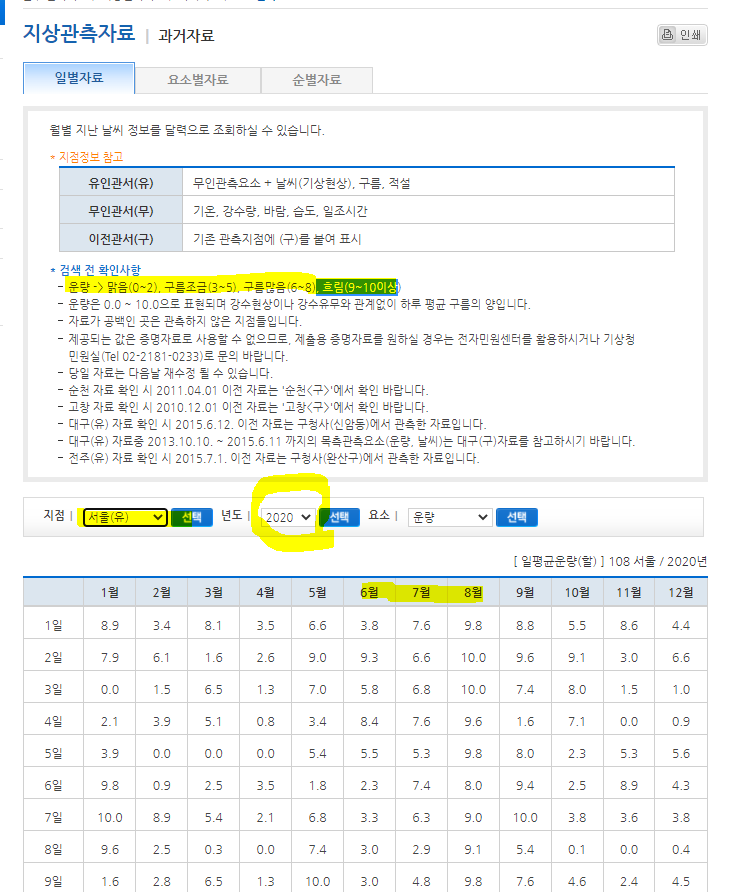


https://hleecaster.com/python-factor-analysis/

In [29]:
daytime_not_rainy_df['weather'] = ['sunny' if s >0.3 else 'cloudy' for s in daytime_not_rainy_df['insolation']]
daytime_not_rainy_df.head(100)

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour,weather
7,1,2020-06-01 07:00:00,8019.000,16.9,2.3,86.0,0.0,0.1,0.0,0.0,7,cloudy
8,1,2020-06-01 08:00:00,8020.944,17.8,3.3,80.0,0.0,0.3,0.0,0.0,8,cloudy
9,1,2020-06-01 09:00:00,8083.152,19.3,2.1,73.0,0.0,0.7,0.0,0.0,9,sunny
10,1,2020-06-01 10:00:00,8116.200,20.5,3.4,62.0,0.0,1.0,0.0,0.0,10,sunny
11,1,2020-06-01 11:00:00,8104.536,22.1,3.6,52.0,0.0,1.0,0.0,0.0,11,sunny
...,...,...,...,...,...,...,...,...,...,...,...,...
159,1,2020-06-07 15:00:00,8620.344,28.4,3.0,45.0,0.0,1.0,0.0,0.0,15,sunny
160,1,2020-06-07 16:00:00,8604.144,28.9,3.2,49.0,0.0,1.0,0.0,0.0,16,sunny
161,1,2020-06-07 17:00:00,8602.200,28.0,3.6,52.0,0.0,1.0,0.0,0.0,17,sunny
162,1,2020-06-07 18:00:00,8585.352,25.7,4.3,62.0,0.0,1.0,0.0,0.0,18,sunny


In [30]:
daytime_not_rainy_df.shape

(64761, 12)

In [31]:
nightTime_not_rainy_df.shape

(38712, 11)

In [32]:
rainy_df.shape

(18927, 12)

In [33]:
humid_avg = daytime_not_rainy_df.groupby('weather').mean('humidity')

In [34]:
humid_avg_cloudy

NameError: name 'humid_avg_cloudy' is not defined

In [35]:
humid_avg = nightTime_not_rainy_df.groupby('weather').mean('humidity')

KeyError: 'weather'

In [36]:
nightTime_not_rainy_df.head()

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,2
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,3
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,4
5,1,2020-06-01 05:00:00,8010.576,16.9,3.4,93.0,0.0,0.0,0.0,0.0,5
21,1,2020-06-01 21:00:00,7974.936,18.6,2.5,55.0,0.0,0.0,0.0,0.0,21


In [37]:
nightTime_not_rainy_df[nightTime_not_rainy_df['insolation']!=0]

,num,datetime,target,temperature,windspeed,humidity,precipitation,insolation,nelec_cool_flag,solar_flag,hour
